In [1]:
# project: p6
# submitter: pjfife
# partner: none
# hours: 9

In [2]:
import geopandas as gpd
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np
import rasterio
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Part 1: Predicting Population using Area
## Q1: How many counties are in Wisconsin?

In [3]:
#Q1
df = gpd.read_file("counties.geojson")
len(df)

72

## Q2: What is the population of each county in WI?

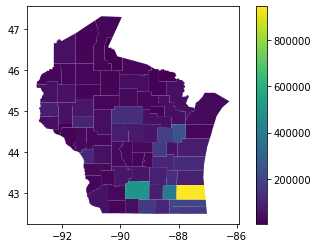

In [4]:
#Q2
ax = df.plot(column = 'POP100', legend = True)

## Q3: What are the counties in the test dataset?

In [5]:
#Q3
conn = sqlite3.connect("counties_tracts.db")
df['AREALAND'] = pd.read_sql("SELECT * FROM counties", conn)['AREALAND']
train, test = train_test_split(df, random_state = 320, test_size = 0.25)

list(test['NAME'])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

## Q4: How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?

In [6]:
#Q4
model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
model.score(test[["AREALAND"]], test["POP100"])

0.022002661530554857

## Q5: What is the predicted population of a county with 500 square miles of area, according to the model?


In [7]:
#Q5
km2 = 500 * 2.59 * 1e6
predicted_df = pd.DataFrame({"AREALAND": [km2]} )
predicted_df['predictedPOP'] = model.predict(predicted_df)
predicted_df['predictedPOP'][0]

82032.53073541154

# Part 2: Predicting Population using Housing Units
## Q6: What are the counties in the test dataset?

In [8]:
#Q6
hu100_df = pd.read_sql("""
SELECT counties.NAME, sum(HU100) as HU100
FROM tracts
INNER JOIN counties ON tracts.COUNTY = counties.COUNTY
GROUP BY counties.NAME
""", conn)

df = pd.merge(df, hu100_df, how = 'inner', on = 'NAME')
train, test = train_test_split(df, random_state = 320, test_size = 0.25)

list(test['NAME'])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

## Q7: What are the HU100 values for the counties in the train dataset?


In [9]:
#Q7
train.drop(columns = ['POP100', 'geometry', 
                      'AREALAND']).set_index('NAME').to_dict()['HU100']

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

## Q8: How much variance in the POP100 can a LinearRegression model explain based only on HU100?

In [10]:
#Q8
scores = cross_val_score(model, train[["HU100"]], train["POP100"])
scores.mean()

0.9652534544116037

## Q9: What is the standard deviation of the cross validation scores from Q8?

In [11]:
#Q9
scores.std()

0.03704265206670459

## Q10: What is the formula relating POP100 and HU100?

In [12]:
#Q10
model.fit(train[['HU100']], train['POP100'])
coef = round(model.coef_[0], 2)
intercept = round(model.intercept_, 2)
f"POP100 = {coef}*HU100 + {intercept}"

'POP100 = 2.39*HU100 + -7910.46'

## Q11: What is the relationship between HU100 and POP100, visually?


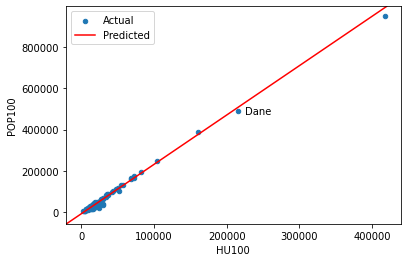

In [13]:
#Q11
dane_pop = df.drop(columns = ["geometry", "AREALAND", 
                   "HU100"]).set_index('NAME').to_dict()["POP100"]['Dane County']

ax = df.plot.scatter(x='HU100', y='POP100', label = 'Actual')
ax.axline((0, intercept), slope = coef, color = 'r', label = 'Predicted')
ax.text(y=dane_pop, x = 225000, s="Dane", verticalalignment = "center")
ax.legend(frameon=True)
None

# Part 3: Land Use Features
## Q12: How many numbers in matrix A are between 2 and 5 (inclusive)?

In [14]:
#Q12
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

g2 = A >= 2
l5 = A <= 5

np.logical_and(g2, l5).astype(int).sum()

12

## Q13: How does Milwaukee County look?


In [15]:
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

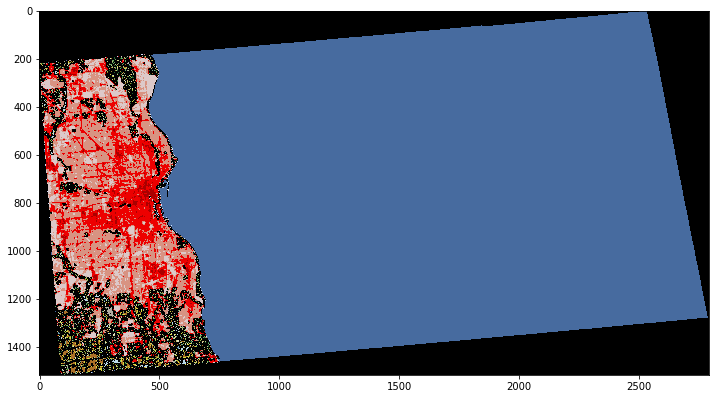

In [16]:
#Q13
land = rasterio.open("zip://../p6/land.zip!wi.tif")
milwaukee = gpd.GeoDataFrame(df.set_index("NAME")['geometry'].loc[["Milwaukee County"]])

matrix, _ = mask(land, milwaukee.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix, vmin=0, vmax=255, cmap = custom_cmap)

## Q14: What portion of Milwaukee County is "Open Water"?

In [17]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

In [18]:
#Q14
mil_total = (matrix != 0).astype(int).sum()
mil_water = (matrix == land_use['open_water']).astype(int).sum()
mil_water / mil_total

0.7963037455950543

## Q15: What is the Relationship Between POP100 and ________________?

In [19]:
def check_proportion(df, interest, col):
    df = df
    di = []
    num_key = land_use[interest]
    for county in df[col]:
        geo_df = gpd.GeoDataFrame(df.set_index("NAME")['geometry'].loc[[county]])
        matrix, _ = mask(land, geo_df.to_crs(land.crs)["geometry"], crop=True)
        matrix = matrix[0]
        check_area = (matrix == num_key).astype(int).sum()
        total_area = (matrix != 0).astype(int).sum()
        di.append(check_area / total_area)
    return di

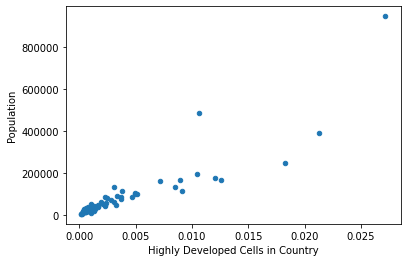

In [20]:
#Q15
di = check_proportion(df, "developed_high", "NAME")
df['prop'] = di
ax = df.plot.scatter(x = "prop", y = "POP100")
ax.set_ylabel("Population")
ax.set_xlabel("Highly Developed Cells in Country")
None

In [21]:
tdf = gpd.read_file("tracts.geojson")

In [22]:
def check2(interest):
    num_key = land_use[interest]
    percent_list = []
    check_area_list = []
    for geoid in tdf['GEOID']:
        county = gpd.GeoDataFrame(tdf.set_index('GEOID')['geometry'].loc[[geoid]])
        matrix, _ = mask(land, county.to_crs(land.crs)["geometry"], crop=True)
        matrix = matrix[0]
        area_total = (matrix != 0).astype(int).sum()
        check_area = (matrix == num_key).astype(int).sum()
        check_area_list.append(check_area)
        percent_list.append(check_area / area_total)
    tdf[interest] = percent_list
    tdf[interest + "_total"] = check_area_list    
    

In [23]:
check2("developed_med")

In [24]:
train, test = train_test_split(tdf, random_state = 320, test_size = 0.25)

In [25]:
m1 = LinearRegression()
m1.fit(train[["developed_med"]], train["POP100"])
scores1 = cross_val_score(m1, train[["developed_med"]], train["POP100"])
print("mean: ", scores1.mean())
print("std: ", scores1.std())

mean:  0.03563542094528738
std:  0.01856432296875382


In [26]:
m2 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])

m2.fit(train[["developed_med_total"]], train["POP100"])
scores2 = cross_val_score(m2, train[["developed_med_total"]], train["POP100"])
print("mean: ", scores2.mean())
print("std: ", scores2.std())

mean:  0.41621273220980004
std:  0.039940216602005855


## Q16: How do the models you selected compare under cross validation?

/home/paytonfife/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/paytonfife/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


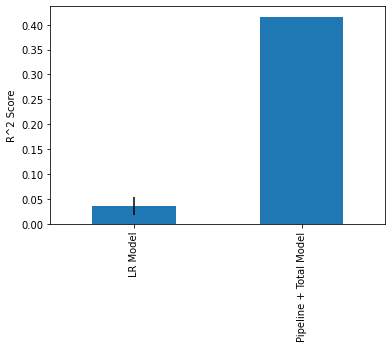

In [27]:
#Q16:
avg = pd.Series({"LR Model": scores1.mean(), "Pipeline + Total Model": scores2.mean()})
std = pd.Series({"LR Model": scores1.std(), "Pipeline  + Total Model": scores2.std()})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")
None

## Q17: How does your recommended model score against the test dataset?

In [28]:
# m1 was my very first idea, trying to use a linear model on the % of area that is "developed_med"
# m2 was my final, and most simple and effective model, using 2 degree PolynomialFeatures and the total area
# covered by "developed_med". Clearly, m2 is much more accurate.

In [29]:
#Q17:
m2.score(test[["developed_med_total"]], test["POP100"])

0.40029704465563754